<a href="https://colab.research.google.com/github/IALeMans/RL-meetup-Reinforcement_Learning/blob/master/RL_GridWorld_DQN_statique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jeu GRID WORLD - DQN

Source https://cdancette.fr/2017/08/20/reinforcement-learning-part2/


## Reinforcement learning sur un jeu simple grâce au Q-learning, Partie 2 : réseau de neurones avec Keras


Jeu statique, le terrain ne change pas, utilisation d’un réseau de neurone pour approximer la fonction de valeurs Q.


> ![Texte alternatif…](https://cdancette.fr/assets/qlearning2/capture.gif) 

Principe :

![Texte alternatif…](https://cdancette.fr/assets/game.png)

## Le jeu

Identique, voir Partie 1 : Un terrain est fixé, avec la position des éléments. Puis l’agent doit apprendre comment gagner le maximum de points en se déplaçant sur ce terrain.

In [0]:
import random

flatten = lambda l: [item for sublist in l for item in sublist]

class Game:
    ACTION_UP = 0
    ACTION_LEFT = 1
    ACTION_DOWN = 2
    ACTION_RIGHT = 3

    ACTIONS = [ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT, ACTION_UP]

    ACTION_NAMES = ["UP   ", "LEFT ", "DOWN ", "RIGHT"]

    MOVEMENTS = {
        ACTION_UP: (1, 0),
        ACTION_RIGHT: (0, 1),
        ACTION_LEFT: (0, -1),
        ACTION_DOWN: (-1, 0)
    }

    num_actions = len(ACTIONS)

    def __init__(self, n, m, wrong_action_p=0.1, alea=False):
        self.n = n
        self.m = m
        self.wrong_action_p = wrong_action_p
        self.alea = alea
        self.generate_game()

    def _position_to_id(self, x, y):
        """Donne l'identifiant de la position entre 0 et 15"""
        return x + y * self.n

    def _id_to_position(self, id):
        """Réciproque de la fonction précédente"""
        return (id % self.n, id // self.n)

    def generate_game(self):
        cases = [(x, y) for x in range(self.n) for y in range(self.m)]
        hole = random.choice(cases)
        cases.remove(hole)
        start = random.choice(cases)
        cases.remove(start)
        end = random.choice(cases)
        cases.remove(end)
        block = random.choice(cases)
        cases.remove(block)

        self.position = start
        self.end = end
        self.hole = hole
        self.block = block
        self.counter = 0
        
        if not self.alea:
            self.start = start
        return self._get_state()
    
    def reset(self):
        if not self.alea:
            self.position = self.start
            self.counter = 0
            return self._get_state()
        else:
            return self.generate_game()

    def _get_grille(self, x, y):
        grille = [
            [0] * self.n for i in range(self.m)
        ]
        grille[x][y] = 1
        return grille

    def _get_state(self):
        x, y = self.position
        if self.alea:
            return [self._get_grille(x, y) for (x, y) in
                    [self.position, self.end, self.hole, self.block]]
        return flatten(self._get_grille(x, y))
    
    def move(self, action):
        """
        takes an action parameter
        :param action : the id of an action
        :return ((state_id, end, hole, block), reward, is_final, actions)
        """
        
        self.counter += 1

        if action not in self.ACTIONS:
            raise Exception("Invalid action")

        # random actions sometimes (2 times over 10 default)
        choice = random.random()
        if choice < self.wrong_action_p:
            action = (action + 1) % 4
        elif choice < 2 * self.wrong_action_p:
            action = (action - 1) % 4

        d_x, d_y = self.MOVEMENTS[action]
        x, y = self.position
        new_x, new_y = x + d_x, y + d_y

        if self.block == (new_x, new_y):
            return self._get_state(), -1, False, self.ACTIONS
        elif self.hole == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), -10, True, None
        elif self.end == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), 10, True, self.ACTIONS
        elif new_x >= self.n or new_y >= self.m or new_x < 0 or new_y < 0:
            return self._get_state(), -1, False, self.ACTIONS
        elif self.counter > 200:
            self.position = new_x, new_y
            return self._get_state(), -1, True, self.ACTIONS
        else:
            self.position = new_x, new_y
            return self._get_state(), -1, False, self.ACTIONS

    def print(self):
        str = ""
        for i in range(self.n - 1, -1, -1):
            for j in range(self.m):
                if (i, j) == self.position:
                    str += "x"
                elif (i, j) == self.block:
                    str += "¤"
                elif (i, j) == self.hole:
                    str += "o"
                elif (i, j) == self.end:
                    str += "@"
                else:
                    str += "."
            str += "\n"
        print(str)

## Le réseau de neurone

Nous allons définir une classe “trainer”, qui sera l’interface avec le réseau de neurone.

Les paramètres de cette classe seront :

* les dimensions du réseau

* le facteur d’actualisation . Il apparait dans la formule d’actualisation du Q learning .

* Le learning rate . Ce sera le learning rate de l’algorithme d’apprentissage du réseau de neurone.

* Le facteur d’exploration , et son coefficient multiplicateur (entre 0 et 1). A chaque étape, sera multiplié par ce facteur.







In [0]:
class Trainer:
    def __init__(self, name=None, learning_rate=0.01, epsilon_decay=0.9999):
        self.state_size = 16
        self.action_size = 4
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.name = name

## Définition du réseau de neurone.

In [0]:
        if name is not None and os.path.isfile("model-" + name):
            model = load_model("model-" + name)
        else:
            model = Sequential()
            model.add(Dense(24, input_shape=(self.state_size,), activation='relu'))
            model.add(Dense(24, activation="relu"))
            model.add(Dense(self.action_size, activation='linear'))
            model.compile(loss='mse', optimizer=sgd(lr=self.learning_rate))

        self.model = model  


  
Les deux premières lignes sont utiles si l’on veut récupérer un modèle préexistant, enregistré sur le disque. La définition du modèle vient juste après :

```model = Sequential() ``` Ceci définit un réseau de neurone constitué de couches successives. Chaque couche que l’on va définir va prendre en entrée la couche précedemment définie.

```
    model.add(Dense(24, input_shape=(self.state_size,), activation='relu'))
    model.add(Dense(24, activation="relu"))
    model.add(Dense(self.action_size, activation='linear'))
 ```

Ici, nous ajoutons 3 couches : 

> La première est constituée de 24 neurones, comme entrée le state (donc d’une taille state_size). L’activation est la fonction non linéaire qui filtre la sortie d’un neurone. 

> La seconde couche (hidden layer) est également constituée de 24 neurones, et de la même fonction d’activation.

> La dernière couche (final layer) possède 4 sorties (self.action_size), une pour chaque action. Pour un état donné en entrée, la valeur que nous renverra chaque neurone sera un tableau de taille 4, chacun contenant la valeur estimée de cette action. Comme dans la parrtie précédente, nous choisirons alors l’action avec la valeur maximale.

Enfin, la ligne  **``` model.compile(loss='mse', optimizer=sgd(lr=self.learning_rate)) ```** indique que la définition est terminée, et qu’on souhaite entrainer le réseau avec l’algorithme **sgd (stochastic gradient descent)**. 

De plus,  **``` loss=mse```** indique que l’on souhaite utiliser la los “mean squared error”, ie que l’on souhaite minimiser l’erreur quadratique moyenne. D’autres loss sont utilisables, mais celle-ci est adaptée à la régression que l’on a ici.

## Entrainement

In [0]:
class Trainer():

    ...

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(np.array([state]))[0]
        if done:
            target[action] = reward
        else:
            target[action] = reward + self.gamma * np.max(self.model.predict(np.array([next_state])))

        inputs = np.array([state])
        outputs = np.array([target])

        return self.model.fit(inputs, outputs, epochs=1, verbose=0, batch_size=1)

Dans cette fonction, nous définissions la base de l’algorithme du Q learning : la mise à jour de Q.

La formule est plus simple que dans le tutoriel précedent. En effet, la vitesse d’apprentissage (learning rate) n’apparait pas ici, car elle est incluse dans l’algorithme d’apprentissage, comme nous verrons plus tard. Nous définissions juste la valeur souhaitée de la valeur de Q pour cet état et cette action.


```

target = self.model.predict(np.array([state]))[0] 

```

Ici, nous récupérons la valeur prédite par le réseau, pour cet état. target est un tableau de taille 4.






```
     if done:
        target[action] = reward
    else:
        target[action] = reward + self.gamma * np.max(self.model.predict(np.array([next_state])))
```

Ici, nous choissions la valeur cible pour l’action que nous avons effectué (nous ne changeons pas la valeur pour les autres actions, puisque nous n’avons pas de donnée sur la reward que aurions obtenu). Si c’est l’état final, la cible est la récompense. Sinon, c’est la récompense, plus la meilleure valeur que nous pourrions obtenir avec l’action suivante (dégradée du facteur d’actualisation )




```
    inputs = np.array([state])
    outputs = np.array([target])

    return self.model.fit(inputs, outputs, epochs=1, verbose=0, batch_size=1)
    
 ```

C’est ici que s’effectue l’apprentissage du réseau : nous indiquons au réseau que pour cet état, il doit renvoyer cette sortie. Le réseau va alors modifier légerement ses poids (par l’algorithme de backpropagation), pour se rapprocher de la sortie désirée.

### meilleure action 

Nous allons enfin définir une méthode qui nous renverra la meilleure action, pour un état donné. Cette fonction nous renverra un état aléatoire selon le paramètre d’exploration .

In [0]:
class Trainer():

    ...

    def get_best_action(self, state, rand=True):
        
        self.epsilon *= self.epsilon_decay

        if rand and np.random.rand() <= self.epsilon:
            # The agent acts randomly
            return random.randrange(self.action_size)
        
        # Predict the reward value based on the given state
        act_values = self.model.predict(np.array([state]))

        # Pick the action based on the predicted reward
        action =  np.argmax(act_values[0])  
        return action

D’abord, on multiplie epsilon par son facteur d’actualisation, de façon a diminuer progressivement l’aléatoire. 

On remarque que la fonction a un argument rand, qui indique si on souhaite une action possiblement aléatoire, ou la meilleure action possible (pas d’exploration).

Le mode rand=False nous servira lorsque le modèle sera entrainé, pour l’utiliser.
On retourne alors une action aléatoire avec une probabilité de , et sinon, la meilleure action. 


On utilise pour cela le réseau de neurone : 


```

self.model.predict(np.array([state])) 


```

nous renvoie les valeurs de chaque action, et il nous suffit de choisir l’action avec la valeur maximale.

In [0]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, sgd
import random
import time
import os

from collections import deque

class Trainer:
    def __init__(self, name=None, learning_rate=0.01, epsilon_decay=0.9999):
        self.state_size = 16
        self.action_size = 4
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        self.name = name
        
        if name is not None and os.path.isfile("model-" + name):
            model = load_model("model-" + name)
        else:
            model = Sequential()
            model.add(Dense(24, input_shape=(self.state_size,), activation='relu'))
            model.add(Dense(24, activation="relu"))
            model.add(Dense(self.action_size, activation='linear'))
            model.compile(loss='mse', optimizer=sgd(lr=self.learning_rate))

        self.model = model       

    def get_best_action(self, state, rand=True):
        
        self.epsilon *= self.epsilon_decay

        if rand and np.random.rand() <= self.epsilon:
            # The agent acts randomly
            return random.randrange(self.action_size)
        
        # Predict the reward value based on the given state
        act_values = self.model.predict(np.array([state]))

        # Pick the action based on the predicted reward
        action =  np.argmax(act_values[0])  
        return action

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(np.array([state]))[0]
        if done:
            target[action] = reward
        else:
            target[action] = reward + self.gamma * np.max(self.model.predict(np.array([next_state])))

        inputs = np.array([state])
        outputs = np.array([target])

        return self.model.fit(inputs, outputs, epochs=1, verbose=0, batch_size=1)
        
    def save(self):
        if self.name:
            self.model.save("model-" + self.name, overwrite=True)
        else:
            self.model.save("model-" + str(time.time()))

## Lancement de l’entrainement

On définit une simple fonction ```train```, qui va boucler sur le nombre d’itérations que l’on souhaite.

In [0]:
import time 

def train(episodes, trainer, game):
    scores = []
    losses = [0]
    for e in range(episodes):
        state = game.reset()
        score = 0  # score in current game
        done = False
        steps = 0  # steps in current game
        while not done:
            steps += 1
            action = trainer.get_best_action(state)
            next_state, reward, done, _ = game.move(action)
            score += reward
            trainer.train(state, action, reward, next_state, done)
            #print(state.index(1), Game.ACTION_NAMES[action], reward, next_state.index(1), "DONE" if done else "")
            state = next_state
            if done:
                scores.append(score)
                break
            if steps > 200:
                trainer.train(state, action, -10, state, True) # we end the game
                scores.append(score)
                break
        if e % 100 == 0: # print log every 100 episode
            print("episode: {}/{}, moves: {}, score: {}"
                  .format(e, episodes, steps, score))
            print(f"epsilon : {trainer.epsilon}")
    #trainer.save()
    return scores

Dans cette boucle se déroule l’algorithme d’apprentissage par renforcement : 

L’agent effectue une action (obtenue par ```trainer.get_best_action```) récupère sa récompense, et le nouvel état. On entraine alors le réseau à associer le score de cet état et cette action à cette récompense par la fonction trainer.train.

On peut alors lancer l’algorithme d’apprentissage :



In [0]:
g = Game(4, 4, 0.1, alea=False) # Un jeu statique, avec 10% d'aléatoire dans les mouvements
g.print()
g._get_state()

..o.
...@
.¤..
..x.



[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


On obtient une grille de ce genre, ou 
* le x représente l’agent, 
* le o le puit, 
* le ¤ le mur 
* et le @ l’arrivée.


> ```
....
..¤x
..o.
@...
```

On lance alors l’entrainement :



In [0]:
trainer = Trainer(learning_rate=0.01)
score = train(2000, trainer, g)

episode: 0/2000, moves: 20, score: -9
epsilon : 0.9980018988604846
episode: 100/2000, moves: 16, score: -5
epsilon : 0.8206899577199985
episode: 200/2000, moves: 6, score: 5
epsilon : 0.7295584680972701
episode: 300/2000, moves: 7, score: 4
epsilon : 0.6653644313547048
episode: 400/2000, moves: 11, score: 0
epsilon : 0.6067581624867086
episode: 500/2000, moves: 5, score: 6
epsilon : 0.5602181755495274
episode: 600/2000, moves: 6, score: 5
epsilon : 0.5129210305423535
episode: 700/2000, moves: 4, score: 7
epsilon : 0.476714718006927
episode: 800/2000, moves: 4, score: 7
epsilon : 0.4475620025503103
episode: 900/2000, moves: 6, score: 5
epsilon : 0.41968812087374857
episode: 1000/2000, moves: 4, score: 7
epsilon : 0.3927638540022978
episode: 1100/2000, moves: 7, score: 4
epsilon : 0.37081588614782407
episode: 1200/2000, moves: 3, score: 8
epsilon : 0.3506550162615826
episode: 1300/2000, moves: 8, score: 3
epsilon : 0.33145765546108874
episode: 1400/2000, moves: 10, score: -19
epsilon : 0

## Courbe de score en fonction de l’itération 

On peut afficher la courbe de score (ici moyennée sur 10 iterations successives)

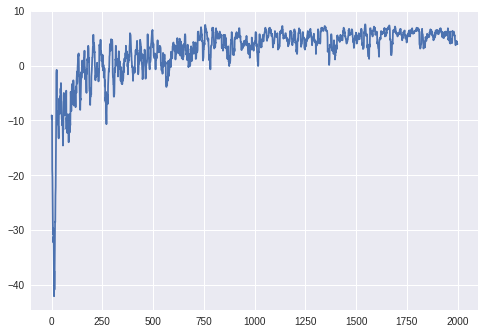

In [0]:
import matplotlib.pyplot as plt
score = np.array(score)
score_c = np.convolve(score, np.full((10,), 1/10), mode="same")
plt.plot(score_c)
plt.show()

Nous pouvons maintenant afficher le résultat. On voit que l’agent a appris à éviter de passer à coté du trou : il préfère prendre le chemin le plus long, où la probabilité de tomber dedans est nulle.

In [0]:
state = g.reset()
state = g._get_state()
done = False
g.print()
while not done:
    time.sleep(1)
    # on selectionne l'action avec rand=False pour choisir toujours la meilleure
    action = trainer.get_best_action(g._get_state(), rand=False)
    next_state, reward, done, _ = g.move(action)
    g.print()

....
.x..
.¤.@
...o

....
..x.
.¤.@
...o

....
...x
.¤.@
...o

....
....
.¤.x
...o

